In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats as stats

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")


import acquire as aq
import prepare as prep

# Preparation

### Reworking a bit of data...
- Since the goal of working with the predictions.csv requires the customer ID column, I decided to rework my aquire.py and prepare.py to fit the needs of the overall project. 
- Below are the results of the dataframe(s) after the rework in the .py files were implemented.

In [2]:
# calling the aquire.py file get_telco_data() function
telco = aq.get_telco_data()

In [3]:
# dropping any duplicate columns : check
telco.drop_duplicates()

# initial overview of the raw telco data retrieved from the SQL
# database

# Here, the idea is to recognize what is needed and what is not.
telco.head()

,internet_service_type_id,payment_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,payment_type,internet_service_type
0,1,2,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,Mailed check,DSL
1,1,2,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,Mailed check,DSL
2,2,1,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Electronic check,Fiber optic
3,2,1,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Electronic check,Fiber optic
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Mailed check,Fiber optic


In [4]:
# Now I check the nulls
telco.isna().sum()

internet_service_type_id    0
payment_type_id             0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
payment_type                0
internet_service_type       0
dtype: int64

### This is where it gets a bit tricky. 
- Ultimately, the gender column will need to be represented in 0's and 1's to properly model them if needed. 
- This is also true when getting certain statistical values on the entire dataframe such as a baseline percentage.

- Certain columns were also replicated into dummy columns and represented by 0's and 1's for later purposes. These columns include:
    - All Contract Types
    - All Payment Types
- Certain columns such as the multiple_lines columns that are objects might cause issues in the future if not fixed now.

In [5]:
# Here I prepared and split the data from my prepare.py file
# function prep_telco()

df = prep.prep_telco(telco)

In [6]:
train, validate, test = df

In [7]:
# for loop of all columns and their dtypes
columns = train.columns
for column in columns:
    if column not in ['customer_id', 'tenure', 'monthly_charges', 'total_charges']:
        print(train[column].value_counts())
        print('---------------------------------------------------')
        print(' ')


Male      1976
Female    1961
Name: gender, dtype: int64
---------------------------------------------------
 
0    3302
1     635
Name: senior_citizen, dtype: int64
---------------------------------------------------
 
0    2027
1    1910
Name: partner, dtype: int64
---------------------------------------------------
 
0    2745
1    1192
Name: dependents, dtype: int64
---------------------------------------------------
 
1    3564
0     373
Name: phone_service, dtype: int64
---------------------------------------------------
 
No                  1895
Yes                 1669
No phone service     373
Name: multiple_lines, dtype: int64
---------------------------------------------------
 
1    2324
0    1613
Name: paperless_billing, dtype: int64
---------------------------------------------------
 
0    2891
1    1046
Name: churn, dtype: int64
---------------------------------------------------
 
Month-to-month    2165
Two year           957
One year           815
Name: contract_type,

### Now to drop duplicate or redundant if needed, and change object columns to integer columns equating 1 = Yes and 0 = No

In [8]:
# mapping gender
train.gender = train.gender.map({'Male':1 , 'Female':0})
train.gender.head()

#mapping yes = 1, no = 1
train.multiple_lines = train.multiple_lines.map({'Yes': 1, 'No': 0,
                                                 'No phone service':2})

# drop columns for which I have a numerical dummy column for
drop_columns = ['contract_type', 'payment_type', 'internet_service_type']
train = train.drop(columns = drop_columns)


### Validate dataset

In [9]:
# mapping gender
validate.gender = validate.gender.map({'Male':1 , 'Female':0})
validate.gender.head()

#mapping yes = 1, no = 1
validate.multiple_lines = validate.multiple_lines.map({'Yes': 1, 'No': 0,
                                                 'No phone service':2})

# drop columns for which I have a numerical dummy column for
drop_columns = ['contract_type', 'payment_type', 'internet_service_type']
validate = validate.drop(columns = drop_columns)

### Test Dataset

In [10]:
# mapping gender
test.gender = test.gender.map({'Male':1 , 'Female':0})
test.gender.head()

#mapping yes = 1, no = 1
test.multiple_lines = test.multiple_lines.map({'Yes': 1, 'No': 0,
                                                 'No phone service':2})

# drop columns for which I have a numerical dummy column for
drop_columns = ['contract_type', 'payment_type', 'internet_service_type']
test = test.drop(columns = drop_columns)

### A lot of the columns look a bit funky with their naming conventions, thus they will be renamed to be quickly accessed and recognizable

In [11]:
train = train.rename(columns={'gender': 'is_male',
                              'contract_type_Month-to-month': 'month_to_month_contract',
                             'contract_type_One year': 'one_year_contract',
                              'ontract_type_Two year': 'two_year_contract', 
                              'payment_type_Bank transfer (automatic)': 'bank_transfer_pay',
                              'payment_type_Credit card (automatic)': 'credit_card_pay', 
                              'payment_type_Electronic check': 'electronic_check_pay', 
                              'payment_type_Mailed check': 'mailed_check_pay', 
                              'internet_service_type_DSL': 'DSL_internet', 
                              'internet_service_type_Fiber optic': 'fiber_optic_internet', 
                              'internet_service_type_None': 'no_internet'})

# Exploring the Data
- Taking note of the few touches I will need to make later, let's just move right in into exploring the data to get an overall sense of what's to come.

## The Goal :

### The goal is to discover features that have the largest impact on the target variable Churn, i.e. provide the most information gain, drive the outcome, and given indepth insight on what direction we can take to reduce it.


### Questions to look for during exploration : 
- Is there unexpected services related to churn, and why? 
- Are those who use mailed checks for payments more or less likely to churn?
- Do customers who have dependents more likely to have longer tenure than those who do not? 
- On average when do month to month customers churn? Is there a significant pattern of churns around a certain amount of tenure? 

In [13]:
# Exploring churn vs telco
# when getting value counts, normalize will return a percentage
train.churn.value_counts(normalize = True)

0    0.734315
1    0.265685
Name: churn, dtype: float64

In [14]:
# realized values
train.churn.value_counts()

0    2891
1    1046
Name: churn, dtype: int64

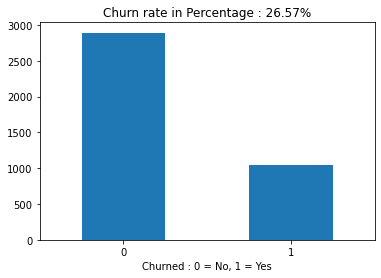

In [15]:
has_churned = (train.churn.mean() * 100)

percent = "{:.2f}".format(has_churned)

train.churn.value_counts().sort_index().plot.bar()
plt.title(f'Churn rate in Percentage : {percent}%')
plt.xlabel('Churned : 0 = No, 1 = Yes')
plt.xticks(rotation = 0)
plt.show()

### Takeaway : 
-  26.57% of Telco customers have churned.
- Now let's figure out what features drive churn.

Text(0, 0.5, 'Features')

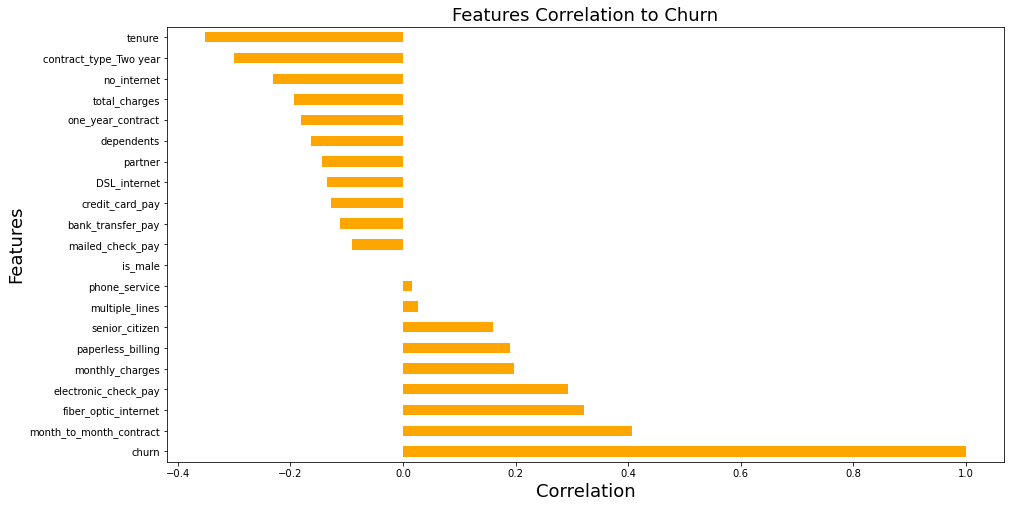

In [16]:
plt.figure(figsize= (15, 8))

train.corr()['churn'].sort_values(ascending=False).plot(kind='barh', 
                                                    color = 'orange')

plt.title('Features Correlation to Churn', fontsize = 18)
plt.xlabel('Correlation', fontsize = 18)
plt.ylabel('Features', fontsize = 18)

## Takeaways : 
- The strongest features with correlations to churn:
    - Month-to-month contracts
    - Fiber optic internet service types
    - Electronic Check Payment Types
    - Monthly charges
    - And perhaps paperless billing
- *While senior citizen is also very much correlated to churn this top five potentially yields the best data.* 

- Tenure, 2 year contracts, total charges and yearly contracts have a strong negative correlation with churn.
- **Sex has no correlation with churn both negative or positive**

### The big questions : 
- Is there unexpected services related to churn, and why? 
- Are those who use mailed checks for payments more or less likely to churn?
- Are customers who have dependents more likely to have longer tenure than those who do not? 
- On average when do month to month customers churn? Is there a significant pattern of churns around a certain amount of tenure? 

### First, let's take a look at each feature and how they relate to churn:

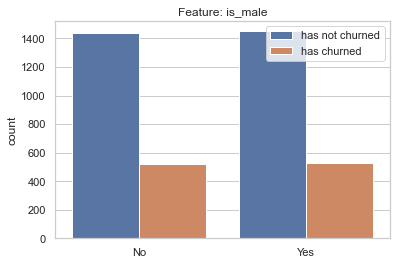

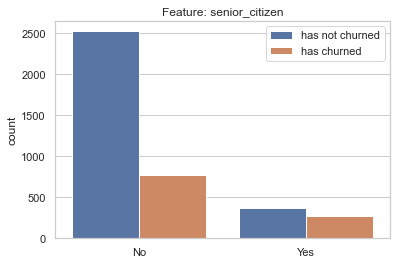

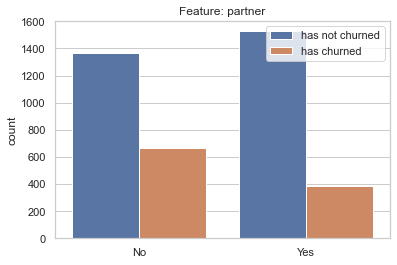

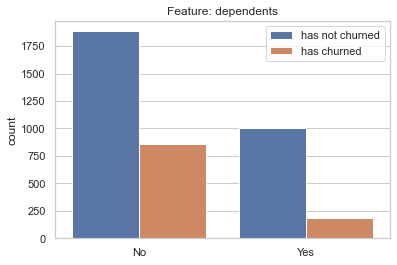

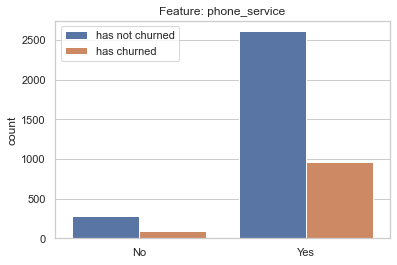

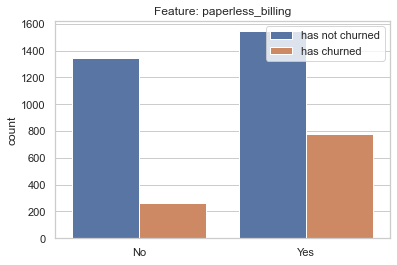

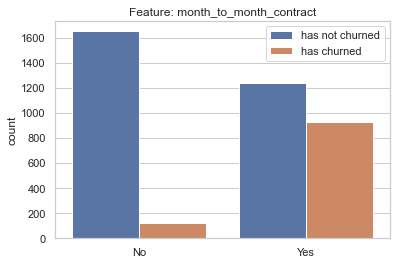

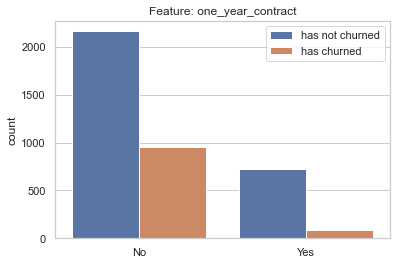

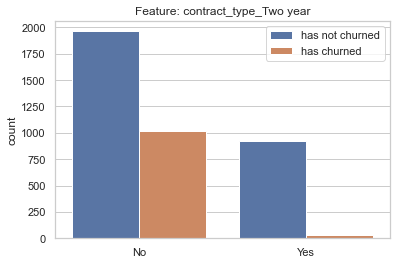

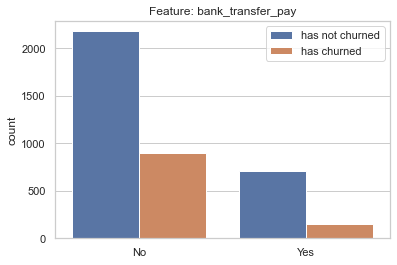

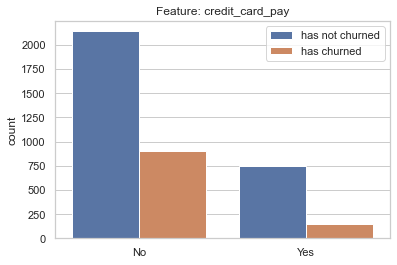

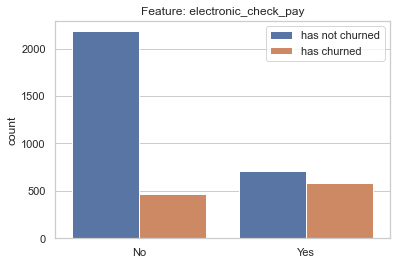

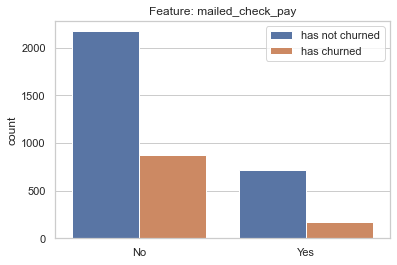

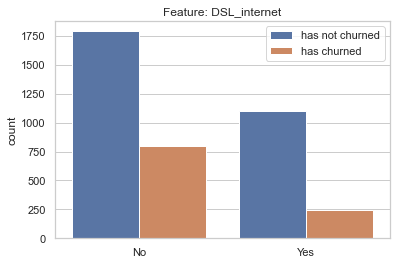

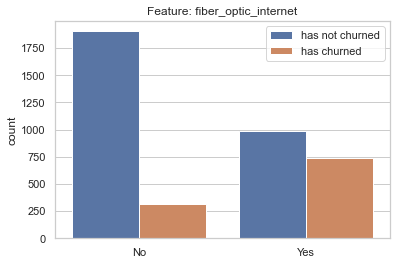

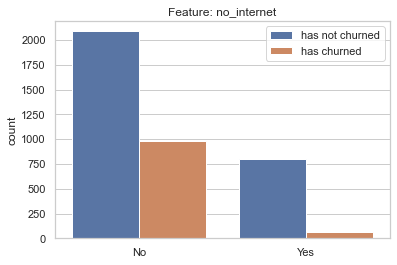

In [17]:
column = train.columns
for col in column:
    if col not in ['customer_id', 'monthly_charges', 'tenure', 'total_charges', 
                   'multiple_lines', 'churn']: 
        sns.set_theme(style="whitegrid")
        ax = sns.countplot(x= train[col], hue="churn",
                           data=train)
        ax.set(xlabel =None)
        ax.set_xticklabels(['No', 'Yes'])
        plt.legend(['has not churned', 'has churned'])
        plt.title(f'Feature: {col}')
        plt.show()

### Takeaways :
- Correlation : 
    - The churn rate on those who are senior citizens is actually rather high, however, there is a very small sample size in comparison to the aggregated count of the entire dataset.
    - Paperlees billing seems to have about a 50% churn rate.
    - month-to-month contracts lose what looks to be about 75% of customers
    - This is the same for electronic checks and fiber optic internet

# Question 1:
### Unexpected Services related to churn : 
- Based on the correlation graph, and count plots a major unexpected feature related to churn would be having fiber optic internet. Because of this obeservation, I will take a look at the internet service types.

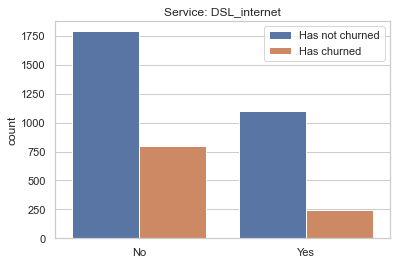

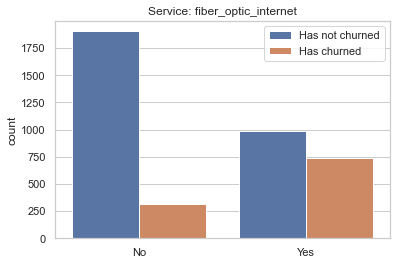

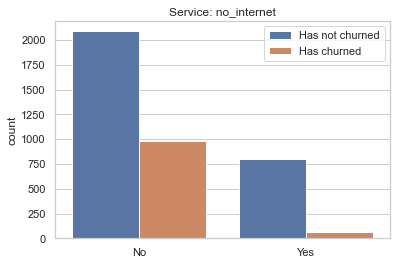

In [19]:
# check internet service types from original telco data

internet_types = ['DSL_internet', 'fiber_optic_internet', 'no_internet']

for types in internet_types:
    sns.set_theme(style="whitegrid")
    ax = sns.countplot(x= train[types], hue="churn",
                       data=train)
    ax.set(xlabel =None)
    ax.set_xticklabels(['No', 'Yes'])
    plt.legend(['Has not churned', 'Has churned'])
    plt.title(f'Service: {types}')
    plt.show()

### Hypothesis

#### ${H_0}$:  Fiber optic internet is independent of churning. They are not correlated.

#### ${H_a}$: Fiber optic internet and churning are dependent on one another and are correlated. 

I will conduct a chi square test on fiber optic internet and churn.

In [20]:
# set alpha
alpha = .05

In [21]:
variable = train.fiber_optic_internet
target = train.churn

observed = pd.crosstab(variable, target)

In [22]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

# test against the null and alternative hypothesis:
if p < alpha:
    print('I reject the null hypothesis that the variables are independent of one another. There is a correlation between them.')
else:
    print('I fail to reject the null hypothesis that the variables are independent of one another. There is no correlation between them')
    

I reject the null hypothesis that the variables are independent of one another. There is a correlation between them.


### I will also take a look at the customers in the multiple phone lines feature

Text(0, 0.5, 'Number of Customers')

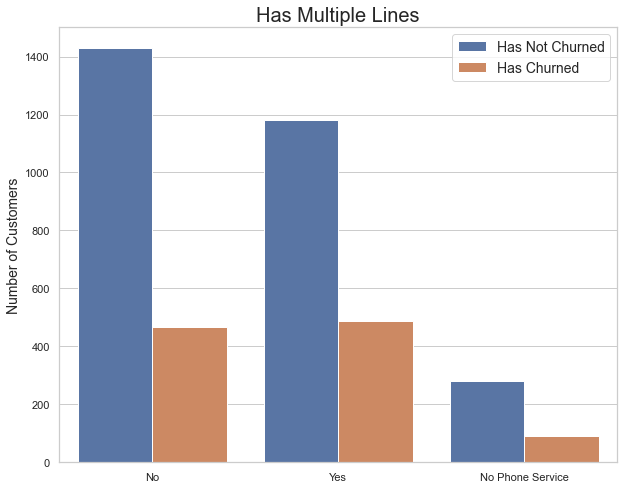

In [23]:
# Looking at the count of customers who have churn vs not churn within the different contract types (using the train data)

plt.figure(figsize = (10, 8))
ax = sns.countplot(x='multiple_lines', hue = 'churn', data = train)
plt.title('Has Multiple Lines', fontsize = 20)
plt.legend(labels = ['Has Not Churned', 'Has Churned'], fontsize = 14)
ax.set(xlabel = None)
ax.set_xticklabels(['No', 'Yes', 'No Phone Service'])
plt.ylabel('Number of Customers', fontsize = 14)

## Takeaways:
- DSL internet has the largest amount of customers by a short margin, with about 25% churn. 
- Fiber optic internet has a 75% churn rate and are more likely to churn. 
- Those with no internet are less likely to churn. 
- Having multiple lines or not doesn't seem to have a strong correlaton to churn.

# Question 2:

### Is payment type related to churn?

#### To find this out, let's run a countplot on all payment types: 

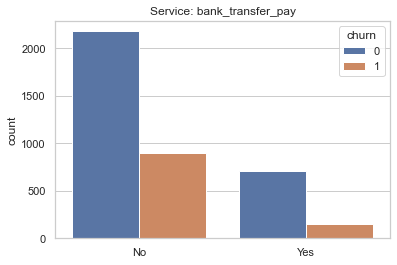

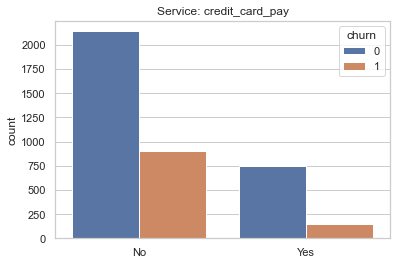

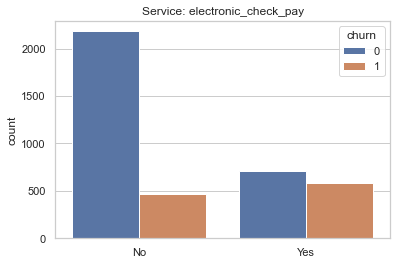

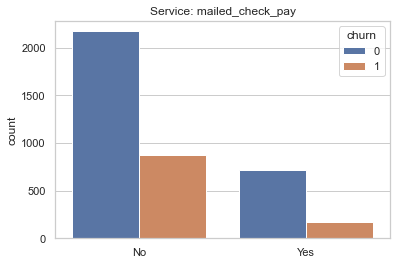

In [24]:
payment_types = ['bank_transfer_pay', 'credit_card_pay',
                 'electronic_check_pay', 'mailed_check_pay']

for types in payment_types:
    sns.set_theme(style="whitegrid")
    ax = sns.countplot(x= train[types], hue="churn",
                       data=train)
    ax.set(xlabel =None)
    ax.set_xticklabels(['No', 'Yes'])
    plt.title(f'Service: {types}')
    plt.show()

### Hypothesis

#### ${H_0}$:  Paying by Electronic Check is independent of churning. They are not correlated.

#### ${H_a}$: Paying by Electronic Check and churning are dependent on one another and are correlated. 

I will conduct a chi square test on Electronic Check Pay and churn.

In [25]:
variable2 = train.electronic_check_pay

#re-used churn target
observed = pd.crosstab(variable, target)

chi2, p, degf, expected = stats.chi2_contingency(observed)

# test against the null and alternative hypothesis:
if p < alpha:
    print('I reject the null hypothesis that the variables are independent of one another. There is a correlation between them.')
else:
    print('I fail to reject the null hypothesis that the variables are independent of one another. There is no correlation between them')

I reject the null hypothesis that the variables are independent of one another. There is a correlation between them.


## Takeaways: 
- Bank transfer and mailed check pay nearly the same amount of customers and the same amount of churn. 
- Mailed Check Pay are less likely to churn
- **Nearly all of the customers in electronic check pay have churned.**
- Credit card pay is the most popular service.

## Question 3 : 

### Are customers who have dependents more likely to have longer tenure than those who do not?

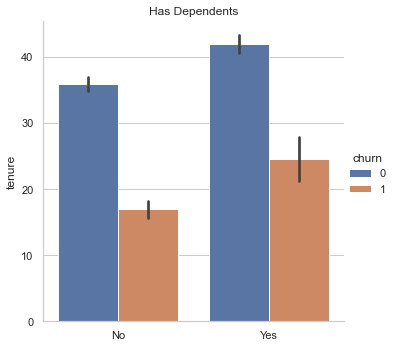

In [56]:
ax3 = sns.catplot(x= 'dependents', y = 'tenure', hue="churn",
                       data=train, kind='bar')
ax.set(xlabel =None)
plt.title(f'Has Dependents')
ax3.set_xticklabels(['No', 'Yes'])
ax3.set(xlabel =None)
plt.show()

### Hypothesis

#### ${H_0}$:  Having Dependents is independent of having higher tenure. They are not correlated.

#### ${H_a}$: Having Dependents and higher tenure are dependent on one another and are correlated. 

I will conduct a 1 sample T-Test on Dependents and Tenure

In [27]:
dependents = train[train.dependents == 1].tenure
tenure_mean = train.tenure.mean()

t, p = stats.ttest_1samp(dependents, tenure_mean)

if p/2 < alpha:
    print('I reject the null hypothesis that the variables are independent of one another. There is a correlation between them.')
else:
    print('I fail to reject the null hypothesis that the variables are independent of one another. There is no correlation between them')
    

I reject the null hypothesis that the variables are independent of one another. There is a correlation between them.


## Takeaways:
- Customers both who have churned and who are still within services who do not have dependents have less tenure than those who do. 

## Question 4 : 

### On average when do month to month customers churn?

In [28]:
# get all month to month contract holders
m2m = train[train.month_to_month_contract == 1]

# get the month to month contract holder who have churned
m2m_churn = m2m[m2m.churn == 1]

# get the average tenure of the month to month contract holders
# who have churned

m2m_churned_avg_tenure = m2m_churn.tenure.mean()

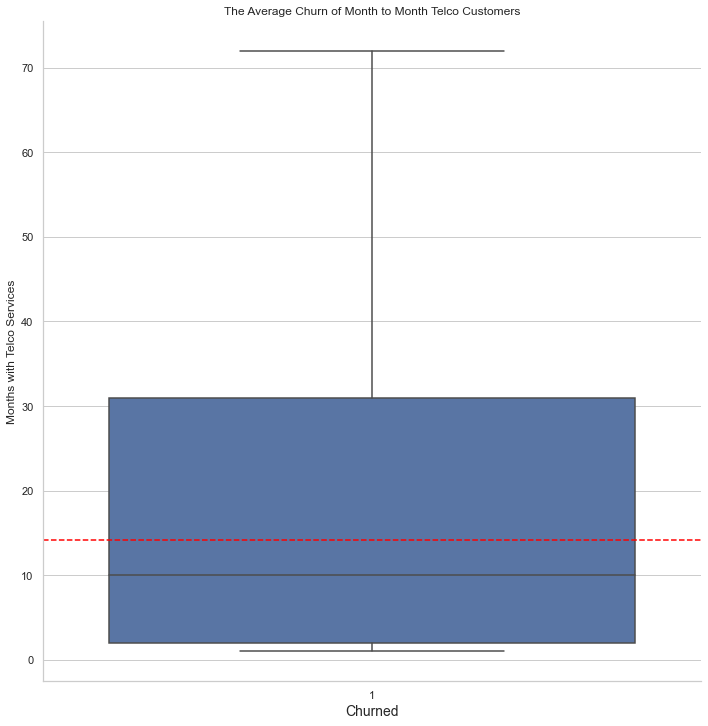

In [29]:
sns.catplot(x='churn', y = 'tenure', kind='box', size=10,
           data = train[train.churn == 1])

plt.title('The Average Churn of Month to Month Telco Customers')

plt.xlabel('Churned', fontsize = 14)

plt.ylabel('Months with Telco Services')

plt.axhline(y= m2m_churned_avg_tenure,
            linestyle = '--', color = 'red')

Text(0, 0.5, 'Customer Count')

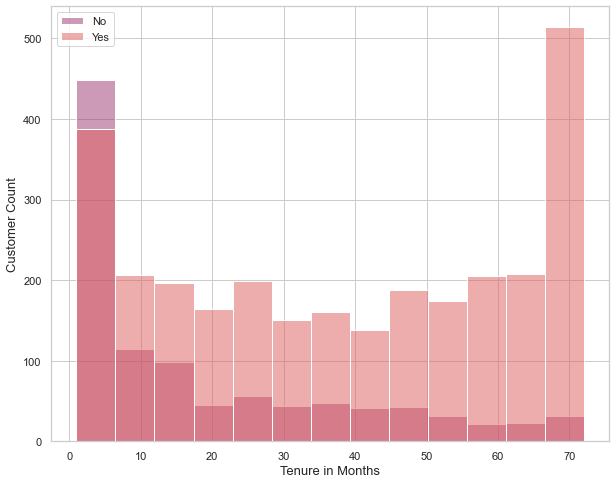

In [30]:
plt.figure(figsize=(10,8))

sns.histplot(data=train, x='tenure', hue='churn',
             palette = 'flare')

plt.legend(['No', 'Yes'])
plt.xlabel('Tenure in Months', fontsize=13)
plt.ylabel('Customer Count', fontsize = 13)


## Takeaways:
- The average Tenure of month to month customers is 14 months.
- However, a majority of those cutomers, churn before their first 10 months with service.

# Modeling

In [31]:
# calculate the baseline for the train dataset

baseline = (train.churn == 0).mean()
print(f'Our baseline accuracy is: {baseline}')

Our baseline accuracy is: 0.7343154686309372


### This baseline of 73% is the accuracy of the amount of customers that we will retain. 

### Our goal is to create a model that will return over 73% retention in customers.

In [32]:
drop_columns = ['customer_id', 'churn', 'multiple_lines']

X_train = train.drop(columns = drop_columns)
y_train = train.churn

X_validate = validate.drop(columns = drop_columns)
y_validate = validate.churn

X_test = test.drop(columns = drop_columns)
y_test = test.churn

In [33]:
X_train.shape

(3937, 19)

In [34]:
X_validate.shape

(1688, 19)

In [35]:
X_test.shape

(1407, 19)

### Random Forest on Train and Validate

In [36]:
metrics = []
max_depth = 12

for i in range(1, max_depth):
    # Make the model
    depth = max_depth - i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, 
                                    min_samples_leaf=n_samples, 
                                    random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df1 = pd.DataFrame(metrics)
df1["difference"] = df1.train_accuracy - df1.validate_accuracy
df1

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,1,11,0.919482,0.780213,0.139269
1,2,10,0.868936,0.790877,0.078059
2,3,9,0.849632,0.781398,0.068234
3,4,8,0.827534,0.783175,0.044358
4,5,7,0.822200,0.778436,0.043764
5,6,6,0.816612,0.778436,0.038176
6,7,5,0.808484,0.785545,0.022939
7,8,4,0.800356,0.781991,0.018365
8,9,3,0.792482,0.776659,0.015823
9,10,2,0.764542,0.751777,0.012764


In [37]:
for i in range(2, 11):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = forest.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                     0            1  accuracy    macro avg  weighted avg
precision     0.762286     0.808290  0.764542     0.785288      0.774509
recall        0.987202     0.149140  0.764542     0.568171      0.764542
f1-score      0.860286     0.251816  0.764542     0.556051      0.698625
support    2891.000000  1046.000000  0.764542  3937.000000   3937.000000

Tree with max depth of 3
                     0            1  accuracy    macro avg  weighted avg
precision     0.800812     0.735656  0.792736     0.768234      0.783501
recall        0.955379     0.343212  0.792736     0.649295      0.792736
f1-score      0.871293     0.468057  0.792736     0.669675      0.764160
support    2891.000000  1046.000000  0.792736  3937.000000   3937.000000

Tree with max depth of 4
                     0            1  accuracy    macro avg  weighted avg
precision     0.813489     0.718430   0.79934     0.765959      0.788233
recall        0.942926     0.402486   0.79934  

In [38]:
df1[df1.difference == df1.difference.max()]

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,1,11,0.919482,0.780213,0.139269


### Takeaways: 

### KNN on Train and Validate

In [39]:
# Evaluate KNearest Neighbors models on train & validate set by looping through different values for k hyperparameter

# create empty list for which to append scores from each loop
scores = []
k_range = range (1,11)
# create loop for range 1-10
for k in k_range:
            
    # define the model setting hyperparameters to values for current loop
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # fit the model on train
    knn.fit(X_train, y_train)
    
    # use the model and evaluate performance on train
    train_accuracy = knn.score(X_train, y_train)
    # use the model and evaluate performance on validate
    validate_accuracy = knn.score(X_validate, y_validate)
    
    # create output of current loop's hyperparameters and accuracy to append to metrics
    output = {
        "k": k,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy
    }
    
    scores.append(output)

# convert scores list to a dataframe for easy reading
df2 = pd.DataFrame(scores)
# add column to assess the difference between train & validate accuracy
df2['difference'] = df2.train_accuracy - df2.validate_accuracy
df2

,k,train_accuracy,validate_accuracy,difference
0,1,0.997714,0.704384,0.293330
1,2,0.860554,0.749408,0.111146
2,3,0.857760,0.742299,0.115461
3,4,0.833376,0.765995,0.067380
4,5,0.831598,0.757701,0.073896
5,6,0.819914,0.768957,0.050956
6,7,0.817882,0.772512,0.045370
7,8,0.813056,0.780806,0.032250
8,9,0.815342,0.776066,0.039275
9,10,0.810008,0.771327,0.038681


In [40]:
df2[df2.difference == df2.difference.min()]

,k,train_accuracy,validate_accuracy,difference
7,8,0.813056,0.780806,0.03225


### Logistic Regression on Train and Validate

In [41]:
# Evaluate Logistic Regression models on train & validate set by looping through different values for c hyperparameter

# create empty list for which to append metrics from each loop
metrics = []

# create loop for values in list
for c in [.001, .005, .01, .05, .1, .5, 1, 5, 10, 50, 100, 500, 1000]:
            
    # define the model setting hyperparameters to values for current loop
    logit = LogisticRegression(C=c)
    
    # fit the model on train
    logit.fit(X_train, y_train)
    
    # use the model and evaluate performance on train
    train_accuracy = logit.score(X_train, y_train)
    # use the model and evaluate performance on validate
    validate_accuracy = logit.score(X_validate, y_validate)
    
    # create output of current loop's hyperparameters and accuracy to append to metrics
    output = {
        'C': c,
        'train_accuracy': train_accuracy,
        'validate_accuracy': validate_accuracy
    }
    
    metrics.append(output)

# convert metrics list to a dataframe for easy reading
df3 = pd.DataFrame(metrics)
# add column to assess the difference between train & validate accuracy
df3['difference'] = df3.train_accuracy - df3.validate_accuracy
df3

,C,train_accuracy,validate_accuracy,difference
0,0.001,0.792228,0.784953,0.007275
1,0.005,0.797308,0.790877,0.006431
2,0.010,0.800610,0.789100,0.011510
3,0.050,0.799594,0.790284,0.009309
4,0.100,0.802642,0.786730,0.015912
5,0.500,0.799848,0.788507,0.011340
6,1.000,0.803404,0.787322,0.016081
7,5.000,0.799340,0.790877,0.008463
8,10.000,0.802896,0.786730,0.016166
9,50.000,0.799594,0.790877,0.008717


### The Logistric Regression model has the most accurate throughout the dataset and has a lower change of overfitting data with minimal differences between both train and validate sets. 

### For the test dataset, I'll be selecting the C value from the model where there is minimal difference between the the accuracy of the train and validate datasets.

In [42]:
df3[df3.difference == df3.difference.min()]

,C,train_accuracy,validate_accuracy,difference
1,0.005,0.797308,0.790877,0.006431


- ###  This will be where the C value = 1

In [43]:
logit = LogisticRegression(C=1)

#fit the data
logit.fit(X_test, y_test)

#score the data
score = (logit.score(X_test, y_test)*100)
score_percent = "{:.2f}".format(score)

print(f'Test Dataset Accuracy Score : {score_percent}%')

Test Dataset Accuracy Score : 81.24%


### Now I will get the predictions...

In [44]:
y_prediction = logit.predict(X_test)

### Then the probability

In [45]:
y_prediction_probability = logit.predict_proba(X_test)

### Finally, I will create the predictions and probability csv file

In [46]:
predictions = pd.DataFrame(columns=['customer_id','probability_of_churn',
                                    'churn_prediction', 'actual_churn'])
predictions['customer_id'] = test.customer_id
predictions['probability_of_churn'] = y_prediction_probability
predictions['churn_prediction'] = y_prediction
predictions['actual_churn'] = test.churn

predictions.churn_prediction = predictions.churn_prediction.map({1: 'Yes', 0: 'No'})
predictions.actual_churn = predictions.actual_churn.map({1: 'Yes', 0: 'No'})

In [47]:
predictions

,customer_id,probability_of_churn,churn_prediction,actual_churn
3311,4716-MRVEN,0.973144,No,No
6330,8966-KZXXA,0.987744,No,No
6156,8720-RQSBJ,0.534560,No,No
5313,7504-UWHNB,0.621188,No,No
1176,1730-VFMWO,0.840876,No,No
...,...,...,...,...
600,0877-SDMBN,0.877360,No,Yes
3946,5555-RNPGT,0.909848,No,No
3230,4628-CTTLA,0.892775,No,Yes
349,0516-QREYC,0.884457,No,No


In [48]:
predictions.actual_churn.value_counts()

No     1033
Yes     374
Name: actual_churn, dtype: int64

In [49]:
predictions.to_csv('telco_churn_prediction.csv')